<h3> Code partially taken from: https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb
https://medium.com/coinmonks/visualizing-brain-imaging-data-fmri-with-python-e1d0358d9dba

In [1]:
#NiBabel supports an ever growing collection of neuroimaging file formats.
#!pip install nibabel
#!pip install utils

In [2]:

import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt
import utils
%matplotlib inline


/Users/zack/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#locate file
data_path1 = '/Users/zack/zack/deep_learning/Play/'
files1 = os.listdir(data_path1)

#read data
data_all1 = []
for data_file1 in files1:
    if data_file1[-6:] == 'nii.gz':
        print(data_file1)
        data1 = nibabel.load(data_path1 + data_file1).get_data()
        break

OAS30002_MR_d0371.nii.gz


In [4]:
data1.shape

(256, 256, 256)

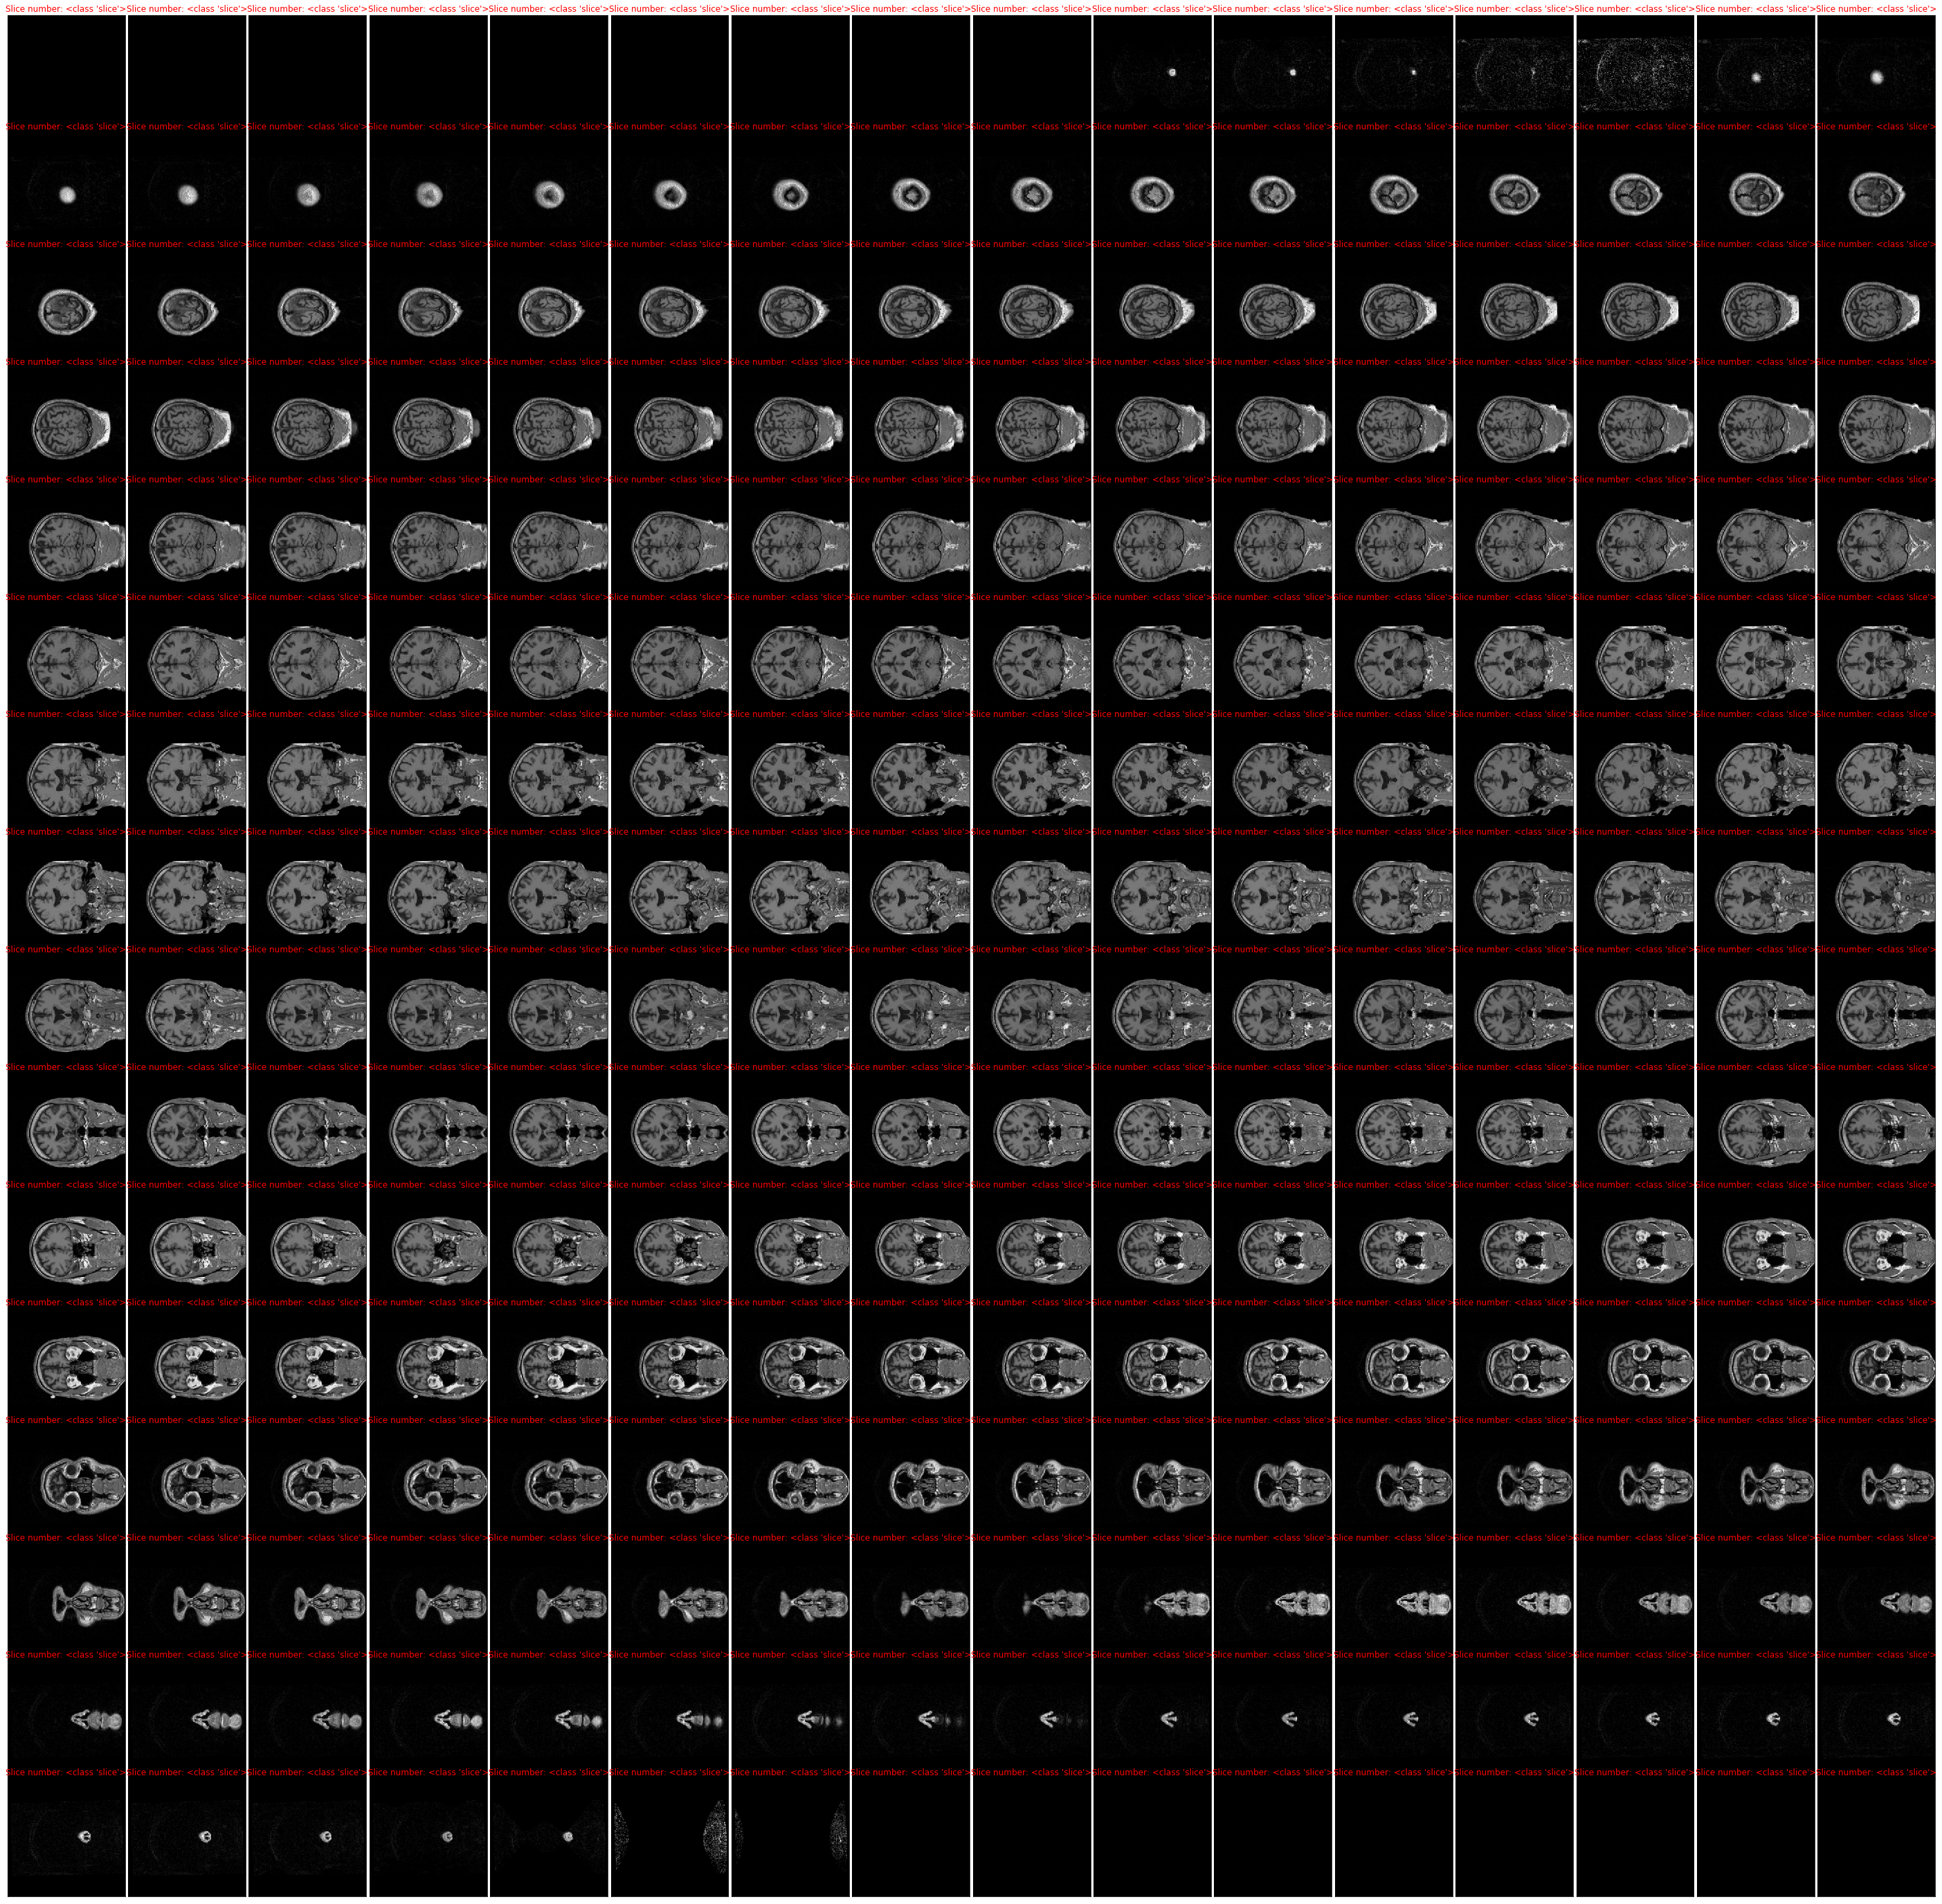

In [5]:
fig, axes = plt.subplots(16,16, figsize=[50,50])

for i, ax in enumerate(axes.flat):
    ax.imshow(data1[:, :, i], 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Slice number: {}'.format(slice), color='r')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

# data preprocessing

In [6]:
import pandas as pd
import numpy as np
import os
import zipfile
import shutil

In [7]:
# data preprocessing


#read oasis_data
labels = pd.read_csv("oasis_label_2.csv")
# days since MRI
labels['Days since MRI'] = pd.to_numeric(labels['Label'].str[-4:])
# month and two month since MRI
labels['Months since MRI'] = np.floor(labels['Days since MRI']/30)
labels['2 months since MRI'] = np.floor(labels['Days since MRI']/60)
# drop subjects who have two mri at the same day 
new = labels
new = new.drop_duplicates(subset=['Subject','2 months since MRI'])
# sort by subject and then months since mri
sorted_labels = new.sort_values(by=['Subject','Months since MRI'])

# need to change format since MRI format is OAS30073_MR_d3670.nii, 
# but nameID on excel file format is OAS30073_ClinicalData_d3670
# OAS30001_ClinicalData_d0000 -> OAS30001_MR_d0000.nii


def rep(s):
    x = s.replace("_ClinicalData_","_MR_")
    return x
sorted_labels['New Label'] = sorted_labels['Label'].apply(rep) + '.nii'

# divide sorted_label into 3 label-normal, uncertain and AD_labels
normal_labels = sorted_labels[sorted_labels['dx1'] == 'Cognitively normal']
uncertain_labels = sorted_labels[sorted_labels['dx1'] == 'uncertain dementia']
AD_labels = sorted_labels[sorted_labels['dx1'] == 'AD Dementia']


sorted_labels['New Label'] = sorted_labels['Label'].apply(rep) + '.nii'
######################################################################################################################

# oasis_image_data_dates.csv matches sorted_labels
image_data = pd.read_csv("oasis_image_data_dates.csv")


def match(df, col1 = 'subject',col2 = 'days'):
    df1=sorted_labels[sorted_labels["Subject"]==df[col1]]
    loc = (np.abs(df1["Days since MRI"] - df[col2])).argmin()            
    low_limit = df[col2] - 180
    high_limit = df[col2] + 180
    if sorted_labels.loc[loc]['Days since MRI'] < high_limit and sorted_labels.loc[loc]['Days since MRI'] > low_limit:
#         #here return dx1 other than the nearest day
#         return int(sorted_labels.loc[loc]['Days since MRI'])
        return sorted_labels.loc[loc]['dx1']

    else:
        return None
image_data["match_label"] = image_data.apply(match,col1 = 'subject',col2 = 'days',axis = 1)
image_data.head()


# def match(day_file,subj_file,excel):
#     df1=excel[excel["Subject"]==subj_file]
#     loc = (np.abs(df1["Days since MRI"] - day_file)).argmin()            
#     low_limit = day_file - 180
#     high_limit = day_file + 180
#     if excel.loc[loc]['Days since MRI'] < high_limit and excel.loc[loc]['Days since MRI'] > low_limit:
#         return excel.loc[loc]['Days since MRI']
#     else:
#         return None
# df['nearest'] = df.apply(lambda x: match(x['days'],x['subject'],sorted_labels),axis=1) 
# df.head()

#get sample file name for AD NORMAL AND UNCERTAIN

sample_normal = image_data[image_data['match_label'] == 'Cognitively normal'].head(50)
normal_file_name = sample_normal['actual file name'].values

sample_AD = image_data[image_data['match_label'] == 'AD Dementia'].head(50)
AD_file_name = sample_AD['actual file name'].values

sample_uncertain = image_data[image_data['match_label'] == 'uncertain dementia'].head(50)
uncertain_file_name = sample_uncertain['actual file name'].values


/Users/zack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


In [8]:
# get sample data
data_path = '/Users/zack/zack/deep_learning/Play/'
files = os.listdir(data_path1)

#read data
X = np.zeros((150,256,256,256))
Y = np.zeros((150,1))
i = 0
# 0 is normal 1 is ad and 2 is uncertain
for data_file in files:
    for normal_name in normal_file_name:
        if data_file == normal_name:
            X[i] = nibabel.load(data_path + data_file).get_data()
            Y[i] = 0
            i += 1
    for AD_name in AD_file_name:
        if data_file == AD_name:
            X[i] = nibabel.load(data_path + data_file).get_data()
            Y[i] = 1
            i += 1
    for uncertain_name in uncertain_file_name:
        if data_file == uncertain_name:
            X[i] = nibabel.load(data_path + data_file).get_data()
            Y[i] = 2
            i += 1
    if i == 150:
             
        break
    

In [9]:
# split into train and test
np.random.seed = 1
indices = np.random.permutation(X.shape[0])
indices

training_idx, test_idx = indices[:100], indices[100:]


X_train, X_test = X[training_idx], X[test_idx]
Y_train, Y_test = Y[training_idx,:], Y[test_idx,:]

y_test_cls = Y_test.squeeze()
y_train_cls = Y_train.squeeze()
y_test_cls.shape




 

(50,)

In [10]:

#get dummy for Y train and test

Y_train = pd.get_dummies(Y_train.squeeze()).values
Y_test = pd.get_dummies(Y_test.squeeze()).values
print(Y_train.shape)

(100, 3)


In [11]:
print(X_train.shape ,X_test.shape ,Y_train.shape,Y_test.shape,y_test_cls.shape,y_train_cls.shape)

(100, 256, 256, 256) (50, 256, 256, 256) (100, 3) (50, 3) (50,) (100,)


In [12]:
X_train = X_train.reshape((100,-1))
X_test = X_test.reshape((50,-1))
print(X_train.shape ,X_test.shape)

(100, 16777216) (50, 16777216)


# CNN MODEL

In [13]:
# cov > pooling > cov2 > pooling2 > fc >fc2 > softmax

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [15]:
#The configuration of the Convolutional Neural Network
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.


In [16]:

##########################################################################
#some of the data-dimensions
#The number of pixels in each dimension of an image.
img_size = 256
# The images are stored in one-dimensional arrays of this length
img_size_flat = 256 *256 * 256
# Tuple with height and width of images used to reshape arrays.
img_shape = (256,256)
# Number of classes, one class for each of 10 digits.
num_classes = 3
# Number of colour channels for the images: 1 channel for gray-scale. Even we are gray, but we have 256 slices
# For us it is slices not colour channels
num_channels = 256

###############################################################################################
#help function for plotting images(later we will add x-label below image)
def plot_images(data1,label_true = None,label_pred = None):
    fig, axes = plt.subplots(16,16, figsize=[100, 100])

    for i, ax in enumerate(axes.flat):
        ax.imshow(data1[:, :, i], 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Slice number: {}'.format(slice), color='r')
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

#Helper-functions for creating new variables
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


###############################################################################################
#Helper-function for creating a new Convolutional Layer

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    # Use pooling to down-sample the image resolution
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights


###############################################################################################
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]
    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

###############################################################################################

# Helper-function for creating a new Fully-Connected Layer

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer



In [17]:
#some of the data-dimensions
#The number of pixels in each dimension of an image.
img_size = 256
# The images are stored in one-dimensional arrays of this length
img_size_flat = 256 *256 * 256
# Tuple with height and width of images used to reshape arrays.
img_shape = (256,256)
# Number of classes, one class for each of 10 digits.
num_classes = 3
# Number of colour channels for the images: 1 channel for gray-scale. Even we are gray, but we have 256 slices
# For us it is slices not colour channels
num_channels = 256

x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

#Convolutional Layer 1
y_true_cls = tf.argmax(y_true, axis=1)

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

#Convolutional Layer 2

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv2)

#Fully-Connected Layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=False)
#Fully-Connected Layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
###Predicted Class
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

#Cost-function to be optimized
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

#Performance Measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [19]:
###############################################################################################
# Split the test-set into smaller batches of this size.
test_batch_size = 10

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = X_test.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j,:]

        # Get the associated labels.
        labels = Y_test[i:j,:]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        

###############################################################################################

#Helper-function to plot confusion matrix
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.
    # cls_pred is an array of the predicted class-number for all images in the test-set.
    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
####################################################################################
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
####################################################################################
#Helper-function to perform optimization iterations
train_batch_size = 30
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    X_train_num = X_train.shape[0]
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):


    
        feed_dict_train = {x: X_train,
                           y_true: Y_train}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 1 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [20]:
#Performance before any optimization
print_test_accuracy()

Accuracy on Test-Set: 32.0% (16 / 50)


In [ ]:
#Performance after 20 optimization iterations

optimize(num_iterations=20)

Optimization Iteration:      1, Training Accuracy:  33.0%


In [ ]:
print_test_accuracy(show_example_errors=True)